#Complete functions:

In [ ]:
from groq import Groq
def chat(prompt, max_tokens = 1024):
  client = Groq(api_key="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")
  completion = client.chat.completions.create(
      model="llama-3.3-70b-versatile",
      messages=[{
          "role":"user",
          "content":[
              {"type": "text", "text": prompt}
          ]
      }],
      temperature=2,
      max_tokens=max_tokens,
  )
  return completion.choices[0].message.content


In [ ]:
# prompt: make a function that passes in the prompt and returns the image generated from freepik

import requests
import json
import base64
from PIL import Image
import io
from IPython.display import display

def generate_freepik_image(prompt):
    # payload = {
    #     "prompt": prompt,
    #     "styling": {
    #         "style": "photo",
    #     }
    # }




    url = "https://api.freepik.com/v1/ai/text-to-image"

    payload = {

        "prompt": prompt,
        "styling": {
            "framing": "first-person",
            "style": "photo"
        },
        "guidance_scale": 1.5,
        "image": {"size": "square_1_1"}
    }

    headers = {
        "x-freepik-api-key": "FPSXa92317cc18924e739a27e0c7b3bdca10", # Replace with your actual API key
        "Content-Type": "application/json"
    }

    try:
        response = requests.request("POST", url, json=payload, headers=headers)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        response_json = response.json()

        image_data = response_json['data'][0]['base64']
        if image_data:
            image_bytes = base64.b64decode(image_data)
            image = Image.open(io.BytesIO(image_bytes))

            return image
        else:
            print("No image data found in the API response.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error during API request: {e}")
        return None
    except (KeyError, IndexError) as e:
        print(f"Error parsing API response: {e}")
        print(response.text) # Print the response for debugging
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [ ]:
def create_image_prompt(product,vibe):
    """
    Generates a prompt for an image generator based on the provided vibe and product.
    The function ensures the image background matches the vibe and aesthetic associated
    with the product, but the product itself is not depicted in the image. The image
    includes empty space in the lower half and is viewed from a natural human height.

    Parameters:
    vibe (str): The desired ambiance or feeling of the image.
    product (str): The product around which the aesthetic is centered.

    Returns:
    str: A detailed prompt describing the desired image background without mentioning the product.
    """

    # Sample description based on the vibe and product
    # description = f"Create and return a prompt to generate an image that embodies the vibe of '{vibe}' with an aesthetic that could be associated with '{product}'. "\
    #               "The background should reflect this ambiance, including elements like colors, textures, and relevant objects or scenery "\
    #               "that suggest the vibe without showing the product itself. The image should be composed with empty space in the lower half, "\
    #               "viewed from a straight-ahead perspective at natural human height. Return only the prompt as your response is sent to the image generator directly"


    description = f"Create and return a prompt to generate an image that will act as the background for an product which will be added later in post-production. the produced image embodies the vibe of '{vibe}' with an aesthetic that could be associated with '{product}'. "\
                  "The background should reflect this ambiance, including elements like colors, textures, and relevant objects or scenery "\
                  "that suggest the vibe without showing the product itself. The image must be composed with empty space in the lower half, there should not be any items in the lower half "\
                  "Return only the answer that you would reply. Donot include any background references and product details. Just to the point answer."

    return description


In [ ]:
def overlay_table(image1_path, image2_path, output_path, offset_ratio=0.0):
    """
    Overlay two images, where image2 (with transparent background (table)) is placed on top of image1.
    Image2 is resized to match image1's dimensions and can be offset vertically.

    Parameters:
    image1_path (str): Path to the base image (determines final size)
    image2_path (str): Path to the overlay image (with transparent background)
    output_path (str): Path where the resulting image will be saved
    offset_ratio (float): Vertical offset as a ratio of image height (0.0 to 1.0)
                         e.g., 0.1 moves image2 down by 10% of the height
    """
    try:
        # Open both images
        try:
          base_img = Image.open(image1_path)
        except:
          base_image = image1_path
        overlay_img = Image.open(image2_path)

        # Convert images to RGBA if they aren't already
        base_img = base_img.convert('RGBA')
        overlay_img = overlay_img.convert('RGBA')

        # Get dimensions from base image
        target_size = base_img.size

        # Resize overlay image to match base image size
        overlay_img = overlay_img.resize(target_size, Image.Resampling.LANCZOS)

        # Calculate vertical offset in pixels
        vertical_offset = int(target_size[1] * offset_ratio)

        # Create a new blank image with the base image size
        result = Image.new('RGBA', target_size, (0, 0, 0, 0))

        # Paste the base image
        result.paste(base_img, (0, 0))

        # Create another transparent layer for the offset overlay
        overlay_layer = Image.new('RGBA', target_size, (0, 0, 0, 0))

        # Paste the overlay image with offset onto the transparent layer
        overlay_layer.paste(overlay_img, (0, vertical_offset), overlay_img)

        # Composite the overlay layer onto the result
        result = Image.alpha_composite(result, overlay_layer)

        # Save the result
        result.save(output_path, 'PNG')

        return result

    except Exception as e:
        print(f"Error processing images: {str(e)}")
        return False

In [ ]:
def overlay_product(image1_path, image2_path, output_path, upward_offset_ratio=0.0, scale_factor=0.45):
    """
    Overlay image2 on top of image1, where:
    - Final image size matches image1
    - Image2 is proportionally scaled to a target height of scale_factor * image1_height
    - Image2 can be offset upward from the bottom

    Parameters:
    image1_path (str): Path to the base image
    image2_path (str): Path to the overlay image (with transparent background)
    output_path (str): Path where the resulting image will be saved
    upward_offset_ratio (float): Upward offset from bottom as ratio of image1 height (0.0 to 1.0)
    scale_factor (float): Target height of image2 as a ratio of image1 height (default 0.75)
    """
    try:
        # Open both images
        base_img = Image.open(image1_path)
        overlay_img = Image.open(image2_path)

        # Convert images to RGBA if they aren't already
        base_img = base_img.convert('RGBA')
        overlay_img = overlay_img.convert('RGBA')

        # Get base image dimensions
        base_width, base_height = base_img.size

        # Calculate target height for overlay image
        target_height = int(base_height * scale_factor)

        # Calculate scaling ratio based on overlay's current height
        scaling_ratio = target_height / overlay_img.size[1]

        # Calculate new width maintaining aspect ratio
        target_width = int(overlay_img.size[0] * scaling_ratio)

        # Resize overlay image
        overlay_img = overlay_img.resize((target_width, target_height), Image.Resampling.LANCZOS)

        # Create result image with base image dimensions
        result = Image.new('RGBA', (base_width, base_height), (0, 0, 0, 0))

        # Paste base image
        result.paste(base_img, (0, 0))

        # Calculate position for overlay image
        x_position = (base_width - target_width) // 2  # Center horizontally
        y_position = base_height - target_height  # Start from bottom

        # Apply upward offset
        upward_offset = int(base_height * upward_offset_ratio)
        y_position -= upward_offset

        # Create transparent layer for overlay
        overlay_layer = Image.new('RGBA', (base_width, base_height), (0, 0, 0, 0))
        overlay_layer.paste(overlay_img, (x_position, y_position), overlay_img)

        # Composite the images
        result = Image.alpha_composite(result, overlay_layer)

        # Save the result
        result.save(output_path, 'PNG')

        return result

    except Exception as e:
        print(f"Error processing images: {str(e)}")
        return False

In [ ]:

def upscale(image,prompt=''):
  url = "https://api.freepik.com/v1/ai/image-upscaler"
  payload = {
      "image":  encode_image(image),
      "scale_factor": "2x",
      "optimized_for": "standard",
      "prompt": prompt,
      "hdr": 1,
      "fractality": 3,
      "engine": "magnific_sparkle",
      "creativity": -3,
      "resemblance": 8
  }

  headers = {
      "x-freepik-api-key": "FPSX7a908e9ab5b64cfa820b29f2c18773a0",
    "Content-Type": "application/json"
  }

  response = requests.request("POST", url, json=payload, headers=headers)

  response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
  response_json = response.json()

  task_id = response_json['data']['task_id']

  return task_id

In [ ]:
def get_img(task_id):
  url = f"https://api.freepik.com/v1/ai/image-upscaler/{task_id}"

  headers = {"x-freepik-api-key": "FPSX7a908e9ab5b64cfa820b29f2c18773a0"}

  response = requests.request("GET", url, headers=headers)
  response_json = response.json()

  # if (response_json['data']['status'] == "COMPLETED" or response_json['data']['status'] =="CREATED"):
  #   print(response_json)
  return response_json['data']['generated']


In [ ]:

def encode_image(image_path):
    """Encodes an image at the given path to a base64 string."""
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return encoded_string
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred during encoding: {e}")
        return None

In [ ]:
#backup if freepik is busy
import random

def get_pollination(prompt):
  width = 768
  height = 768
  seed = random.randint(1, 100) # Each seed generates a new image variation
  model = 'flux' # Using 'flux' as default if model is not provided

  image_url = f"https://pollinations.ai/p/{prompt}?width={width}&height={height}&seed={seed}&model={model}"

  try:
      response = requests.get(image_url, stream=True)
      response.raise_for_status()  # Raise an exception for bad status codes
      image = Image.open(BytesIO(response.content))
      return image
  except requests.exceptions.RequestException as e:
      print(f"Error downloading image: {e}")
      return None
  except Exception as e:
      print(f"Error processing image: {e}")
      return None

In [ ]:
def choose_prod_photo(product, background_prompt, product_dict):
  """
    Makes call to choose product image as per product
  """

  prompt = f"""
  You are an expert designer. Based on the background prompt and product name, choose the best product image file that fits the background.

  Background Prompt: "{background_prompt}"
  Product Name: {product}

  Here are the available product image options:
  """

  for file_path, details in product_dict.items():
      details_str = ", ".join(f"{key}: {value}" for key, value in details.items())
      prompt += f"\n- File: {file_path}, Details: {details_str}"

  prompt += "\n\nReturn the file path of the best matching table only. without any additional text"

  # Get the LLM response
  response = chat(prompt)
  return response.strip()

In [ ]:
def choose_table(product, background_prompt):
  """
    Makes call to choose table image as per product
  """
  dic={
    "/models_assets/tables/image copy 2.png": {
        "Type": "Wooden",
        "Color": "Brown",
        "Appearance": "Polished",
        "Vibe": "Rustic",
        "Texture": "Grained"
    },

    "/models_assets/tables/image copy 3.png": {
    "Type": "Modern",
    "Color": "Light",
    "Appearance": "Matte",
    "Vibe": "Minimalist",
    "Texture": "Smooth"
    },

    "/models_assets/tables/image copy 4.png": {
    "Type": "Contemporary",
    "Color": "white",
    "Appearance": "Polished",
    "Vibe": "Sleek",
    "Texture": "Smooth"
    },

    "/models_assets/tables/image copy 6.png": {
    "Type": "Office",
    "Color": "Wood",
    "Appearance": "Matte",
    "Vibe": "Professional",
    "Texture": "Smooth"
    },

    "/models_assets/tables/image copy 7.png":  {
    "Type": "Dining",
    "Color": "Light-Wood",
    "Appearance": "Natural",
    "Vibe": "Casual",
    "Texture": "Grained"
    },

    "/models_assets/tables/image copy 8.png": {
    "Type": "Rustic",
    "Color": "Dark-Wood",
    "Appearance": "Glossy",
    "Vibe": "Elegant",
    "Texture": "Richly-Grained"
    },

    "/models_assets/tables/image copy 9.png": {
    "Type": "Modern",
    "Color": "White-Marble",
    "Appearance": "Glossy",
    "Vibe": "Luxurious",
    "Texture": "Smooth"
    },

    "/models_assets/tables/image copy 10.png": {
    "Type": "Industrial",
    "Color": "Concrete",
    "Appearance": "Matte",
    "Vibe": "Minimalist",
    "Texture": "Textured"
    },

    "/models_assets/tables/image copy 11.png": {
    "Type": "Elegant",
    "Color": "White-Marble",
    "Appearance": "Polished",
    "Vibe": "Sophisticated",
    "Texture": "Veined"
    },

    "/models_assets/tables/image copy 12.png": {
    "Type": "Modern",
    "Color": "Black",
    "Appearance": "Glossy",
    "Vibe": "Sleek",
    "Texture": "Smooth"
    },

    "/models_assets/tables/image copy 13.png": {
    "Type": "Outdoor",
    "Color": "Honey-Wood",
    "Appearance": "Natural",
    "Vibe": "Rustic",
    "Texture": "Textured"
    },

    "/models_assets/tables/image copy.png": {
    "Type": "Contemporary",
    "Color": "Natural-Wood",
    "Appearance": "Satin",
    "Vibe": "Modern",
    "Texture": "Smooth-Grained"
    },

    "/models_assets/tables/image.png":  {
    "Type": "Craft",
    "Color": "Light-Wood",
    "Appearance": "Matte",
    "Vibe": "Artistic",
    "Texture": "Fine-Grained"
    },

    "/models_assets/tables/table1_trans.png": {
    "Type": "Rustic",
    "Color": "Weathered-Wood",
    "Appearance": "Distressed",
    "Vibe": "Vintage",
    "Texture": "Rough-Grained"
    },

    "/models_assets/tables/table2_trans.png": {
    "Type": "Picnic",
    "Color": "Pine-Wood",
    "Appearance": "Polished",
    "Vibe": "Country",
    "Texture": "Smooth"
    },
  }
  prompt = f"""
  You are an expert designer. Based on the background prompt and product name, choose the best table file that complements them.

  Background Prompt: "{background_prompt}"
  Product Name: {product}

  Here are the available table options:
  """

  for file_path, details in dic.items():
      details_str = ", ".join(f"{key}: {value}" for key, value in details.items())
      prompt += f"\n- File: {file_path}, Details: {details_str}"

  prompt += "\n\nReturn the file path of the best matching table only. without any additional text"

  # Get the LLM response
  response = chat(prompt)
  return response.strip()


In [ ]:
def create_image_prompt_ocassion( product,vibe="festive"):

    """
    Generates a prompt for an image generator based on the provided vibe and product.
    The function ensures the image background matches the vibe and aesthetic associated
    with the product, but the product itself is not depicted in the image. The image
    includes empty space in the lower half and is viewed from a natural human height.

    Parameters:
    vibe (str): The desired ambiance or feeling of the image.
    product (str): The product around which the aesthetic is centered.

    Returns:
    str: A detailed prompt describing the desired image background without mentioning the product.
    """

    # Sample description based on the vibe and product
    # description = f"Create and return a prompt to generate an image that embodies the vibe of '{vibe}' with an aesthetic that could be associated with '{product}'. "\
    #               "The background should reflect this ambiance, including elements like colors, textures, and relevant objects or scenery "\
    #               "that suggest the vibe without showing the product itself. The image should be composed with empty space in the lower half, "\
    #               "viewed from a straight-ahead perspective at natural human height. Return only the prompt as your response is sent to the image generator directly"

    occasions = {
        "Maghe Sankranti":"Create an image that combines festive elements of Maghe Sankranti. Include a colorful kite alongside a traditional wooden spinning top, set against a vibrant purple background. Adjacent to these, place a platter of round small sesame and puffed rice  laddus in a plate. Additionally, depict two traditional brass bowls, one filled with sesame seed balls and the other with cubes of jaggery, set on an ornate wooden tray. This composition should evoke the playful and joyous atmosphere of Maghe Sankranti while highlighting the traditional foods associated with the festival.",
        "Holi": "Create a vibrant and colorful image that captures the spirit of Holi, the festival of colors, without showing any human. The scene should feature a festive environment with colorful powders scattered in the air and on the ground, creating a vivid, multicolored landscape. Include elements like small, empty bowls of different colors that were used to hold the powders. The background should show trees and bushes lightly dusted with various hues of Holi powders, and the ground should be splattered artistically with a mix of bright colors. Add festive decorations such as colorful ribbons and paper streamers to enhance the celebratory atmosphere, all set under a bright, clear sky.",
        "Sahid Diwas": "Create a solemn and respectful image to commemorate Martyrs' Day in Nepal. The scene should feature a central monument or memorial, elegantly designed, representing the courage and sacrifice of the martyrs. Surround the monument with multiple lit oil lamps, casting a gentle glow that signifies remembrance and honor. Include a backdrop of the Nepalese national flag, subtly woven into the scene, emphasizing national pride. The setting should be serene, with a wreath of marigold flowers placed at the base of the monument as a tribute. The atmosphere should convey reverence and gratitude, capturing the solemnity of the day without any human figures, focusing solely on the symbolic elements of remembrance.",
        "Basant Panchami": "Create a vibrant and colorful image celebrating Basant Panchami, focusing on the symbolic elements associated with knowledge and the arts. Feature an elegantly arranged scene surrounded by neatly stacked books and writing instruments, all adorned with marigold flowers and soft petals. Include subtle elements like floating lotus flowers and peacock feathers in the background, enhancing the festive and cultural atmosphere. The setting should be bright and colorful, echoing the spirit of spring, with no human figures or faces of deities, maintaining a focus on the items symbolic of learning and creativity.",
        "Sonam Losar":"Create a festive and culturally rich image to celebrate Sonam Losar, the Tamang New Year. The scene should feature traditional Tamang elements such as colorful prayer flags, and a khapse (a traditional fried pastry), prominently displayed on a vibrant, decorative cloth. Include a depiction of the twelve animals of the Tibetan zodiac, with the animal representing the current year highlighted. The background should reflect the Himalayan mountains, symbolizing the region's geography. The setting should be festive with a warm and welcoming atmosphere, using a color palette of red, yellow, and green to represent prosperity, peace, and harmony. This image should be simple yet symbolic, suitable for a post that celebrates the cultural heritage and traditions of the Tamang community during Sonam Losar.",
    }

    if product in occasions:
          description = f"""
          Create and return a prompt to generate an image that embodies the vibe of '{(vibe if (product!='Sahid Diwas') else 'bravery')}' with an aesthetic that could be associated with the occasion : '{product}'.The description of occasion  are {occasions[product]}
                  The background should reflect this ambiance, including elements like colors, textures, and relevant objects or scenery
                  that suggest the given occasion.the prompt must ensure that there should not be any human face in the photo . Also it should not include face of any gods as well.Faces of the god should not be shown in the statue as well.
                  Return only the answer that you would reply. Donot include any background references . Just to the point answer.

                  """
          return description




    description = f"Create and return a prompt to generate an image that embodies the vibe of '{vibe}' with an aesthetic that could be associated with the occasion : '{product}'. "\
                "The background should reflect this ambiance, including elements like colors, textures, and relevant objects or scenery "\
                "that suggest the given occasion. "\
                " Return only the answer that you would reply. Donot include any background references . Just to the point answer."

    return description

In [ ]:
def festive_photo(festival,vibe='' ):
  while True:
    try:
      prompt = chat(create_image_prompt_ocassion(festival, vibe))
      break
    except Exception as e:
      continue

  try:
    image = generate_freepik_image(prompt)
  except:
    image = None
  if image is None or image == False:  # Check if image is None or False
    prompt = chat(create_image_prompt_ocassion(festival, vibe), 512)
    image = get_pollination(prompt)
    if image is None:
      print("Both Freepik and Pollination failed to generate an image.")
      return None

  return image



In [ ]:
import requests
import json
import os
from PIL import Image
import io
import base64
from IPython.display import display
from io import BytesIO

def load_image_from_url(url):
    """Loads an image from a URL and returns a PIL Image object."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        image = Image.open(BytesIO(response.content))
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [ ]:
import time

def product_photo(product,vibe, prod_size=.55, table = True,  prod_img = 'models\models_assets\file.png'):


  while True:
    try:
      prompt = chat(create_image_prompt(product, vibe))
      break
    except Exception as e:
      continue


  try:
    image = generate_freepik_image(prompt)
  except:
    image = None
  if image is None or image == False:  # Check if image is None or False
    prompt = chat(create_image_prompt(product, vibe), 512)
    image = get_pollination(prompt)
    if image is None:
      print("Both Freepik and Pollination failed to generate an image.")
      return None

  # display(image)
  if image:
      # Generate a unique filename
      import uuid
      unique_filename = str(uuid.uuid4()) + ".png"  # Use UUID for uniqueness
      filepath = os.path.join("/content", unique_filename) # Save in /content directory

      # Save the image with the unique filename
      image.save(filepath)
      print(f"Image saved as: {unique_filename}")


  if (table):
    while True:
      try:
        table_img =overlay_table(unique_filename, choose_table(product, prompt), filepath,.1)
        print("Table overlay successful")
        break
      except:
        continue
  while True:
    try:
      im = overlay_product(filepath, prod_img, 'image44.png',.05, prod_size)
      print("Product overlay successful")
      break
    except:
      try:
        im = overlay_product(filepath, 'models\models_assets\file.png', 'image44.png',.05, prod_size)
        print("Product overlay successful")
        break
      except:
        continue


  #To upscale:
  try:
    task_id = upscale('image44.png', '(realistic:1.6), (proper lighting:1.2)')

    print('ok')
    while True:
      if (get_img(task_id)):
        break
      time.sleep(5)


    fin_img = load_image_from_url(get_img(task_id)[0])
  except:
    fin_img = im
  return (fin_img, prompt)



In [456]:
im,p = product_photo('cold drink', 'warm and refreshing', prod_size=.75,  prod_img = 'models\models_assets\file.png')

Image saved as: f41fe5c7-c35d-4116-b7c3-18a14a60344f.png
Table overlay successful
Product overlay successful


In [457]:
p

'Create an image of a serene summer lawn scene with a warm and refreshing vibe, featuring a blurred canopy of lush green trees, a few leaves and vines, soft filtered sunlight, and a rustic wooden picnic table or worn bench in the upper half, with soft pastel colored exotic flowers scattered here and there. In the lower half, keep the space completely empty with a textured warmth suggestion of sunny cutoff with an underlying off white surface or slight hay tones with very light subtle wooden textures to suggest a calming ambiance that fits an atmosphere for relaxation on a hot summer day near icy mist, light glows, reflecting off sparkling, subtle, and sophisticated, all woven with adequate negative space.'

In [458]:
f = festive_photo('Holi')

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import textwrap
from typing import Tuple, Optional, Literal
import numpy as np

def create_gradient_color(start_color: Tuple[int, int, int],
                         end_color: Tuple[int, int, int],
                         steps: int) -> list:
    """Create a gradient between two RGB colors."""
    gradient = []
    for i in range(steps):
        ratio = i / (steps - 1)
        r = int(start_color[0] * (1 - ratio) + end_color[0] * ratio)
        g = int(start_color[1] * (1 - ratio) + end_color[1] * ratio)
        b = int(start_color[2] * (1 - ratio) + end_color[2] * ratio)
        gradient.append((r, g, b))
    return gradient

def add_text(
    image_path: str,
    text: str,
    font_ratio: float = 0.1,
    font_path: Optional[str] = None,
    color: Tuple[int, int, int] = (255, 255, 255),
    gradient_end_color: Optional[Tuple[int, int, int]] = None,
    position_ratio: Tuple[float, float] = (0.5, 0.5),
    alignment: Literal['left', 'center', 'right'] = 'center'
) -> Image.Image:
    """
    Add text to an image with advanced formatting options.

    Args:
        image_path: Path to input image
        text: Text to add
        font_ratio: Font size as ratio of image height
        font_path: Path to font file (.ttf)
        color: Base RGB color tuple
        gradient_end_color: Optional end color for gradient effect
        position_ratio: (x, y) position as ratios of image width/height
        alignment: Text alignment ('left', 'center', 'right')

    Returns:
        PIL.Image: Image with added text
    """
    try:
      img = Image.open(image_path).convert('RGBA')
    except:
      img = image_path
    draw = ImageDraw.Draw(img)

    # Initialize font
    font_size = 1
    max_attempts = 200

    try:
        font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default()
    except Exception:
        font = ImageFont.load_default()

    # Calculate target height and adjust font size
    target_height = img.size[1] * font_ratio
    total_height = 0

    while total_height < target_height and font_size < max_attempts:
        font_size += 1
        try:
            font = ImageFont.truetype(font_path, font_size) if font_path else font.font_variant(size=font_size)
        except Exception:
            font = ImageFont.load_default().font_variant(size=font_size)
        bbox = draw.textbbox((0, 0), "Ay", font=font)  # Use "Ay" for better height estimation
        total_height = bbox[3] - bbox[1]

    # Calculate maximum width available for text
    max_width = int(img.size[0] * 0.9)  # Use 90% of image width

    # Wrap text to fit width
    space_width = draw.textlength(" ", font=font)
    avg_char_width = draw.textlength("x", font=font)
    chars_per_line = max(1, int(max_width / avg_char_width))
    wrapped_text = textwrap.fill(text, width=chars_per_line)
    lines = wrapped_text.split('\n')

    # Calculate total text block dimensions
    line_spacing = total_height * 1.2  # 20% extra space between lines
    text_block_height = line_spacing * len(lines)
    max_line_width = max(draw.textlength(line, font=font) for line in lines)

    # Calculate starting position
    x_base = int(img.size[0] * position_ratio[0])
    y_base = int(img.size[1] * position_ratio[1] - text_block_height / 2)

    # Draw each line
    for i, line in enumerate(lines):
        # Calculate line width and position
        line_width = draw.textlength(line, font=font)

        if alignment == 'center':
            x = x_base - line_width / 2
        elif alignment == 'right':
            x = x_base - line_width
        else:  # left
            x = x_base

        y = y_base + i * line_spacing

        if gradient_end_color:
            # Create gradient for this line
            chars = list(line)
            x_current = x
            gradient_colors = create_gradient_color(color, gradient_end_color, len(chars))

            for char, char_color in zip(chars, gradient_colors):
                char_width = draw.textlength(char, font=font)
                draw.text((x_current, y), char, font=font, fill=char_color)
                x_current += char_width
        else:
            draw.text((x, y), line, font=font, fill=color)

    return img

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

def add_top_gradient_overlay(image_path, primary_color):
    # Open and convert image to RGBA
    try:
      img = Image.open(image_path).convert('RGBA')
    except:
      img = image_path.convert('RGBA')
    width, height = img.size

    # Create a transparent overlay
    overlay = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Convert primary color to RGB tuple
    color_map = {
        'red': (255, 0, 0),
        'blue': (0, 0, 255),
        'green': (0, 255, 0)
    }

    if isinstance(primary_color, str):
        color = color_map.get(primary_color.lower(), (255, 0, 0))
    else:
        color = primary_color

    # Calculate gradient parameters
    gradient_height = int(height * 0.75)  # 75% of image height
    start_y = 0

    # Create gradient overlay
    for y in range(start_y, height):
        # Calculate opacity (alpha) based on position
        progress = (y - start_y) / (height - start_y)
        alpha = int(204 * (1 - progress))  # 204 is 80% of 255

        # Draw line with calculated opacity
        draw.line([(0, y), (width, y)], fill=color + (alpha,))

    # Composite original image with overlay
    result = Image.alpha_composite(img, overlay)

    return result



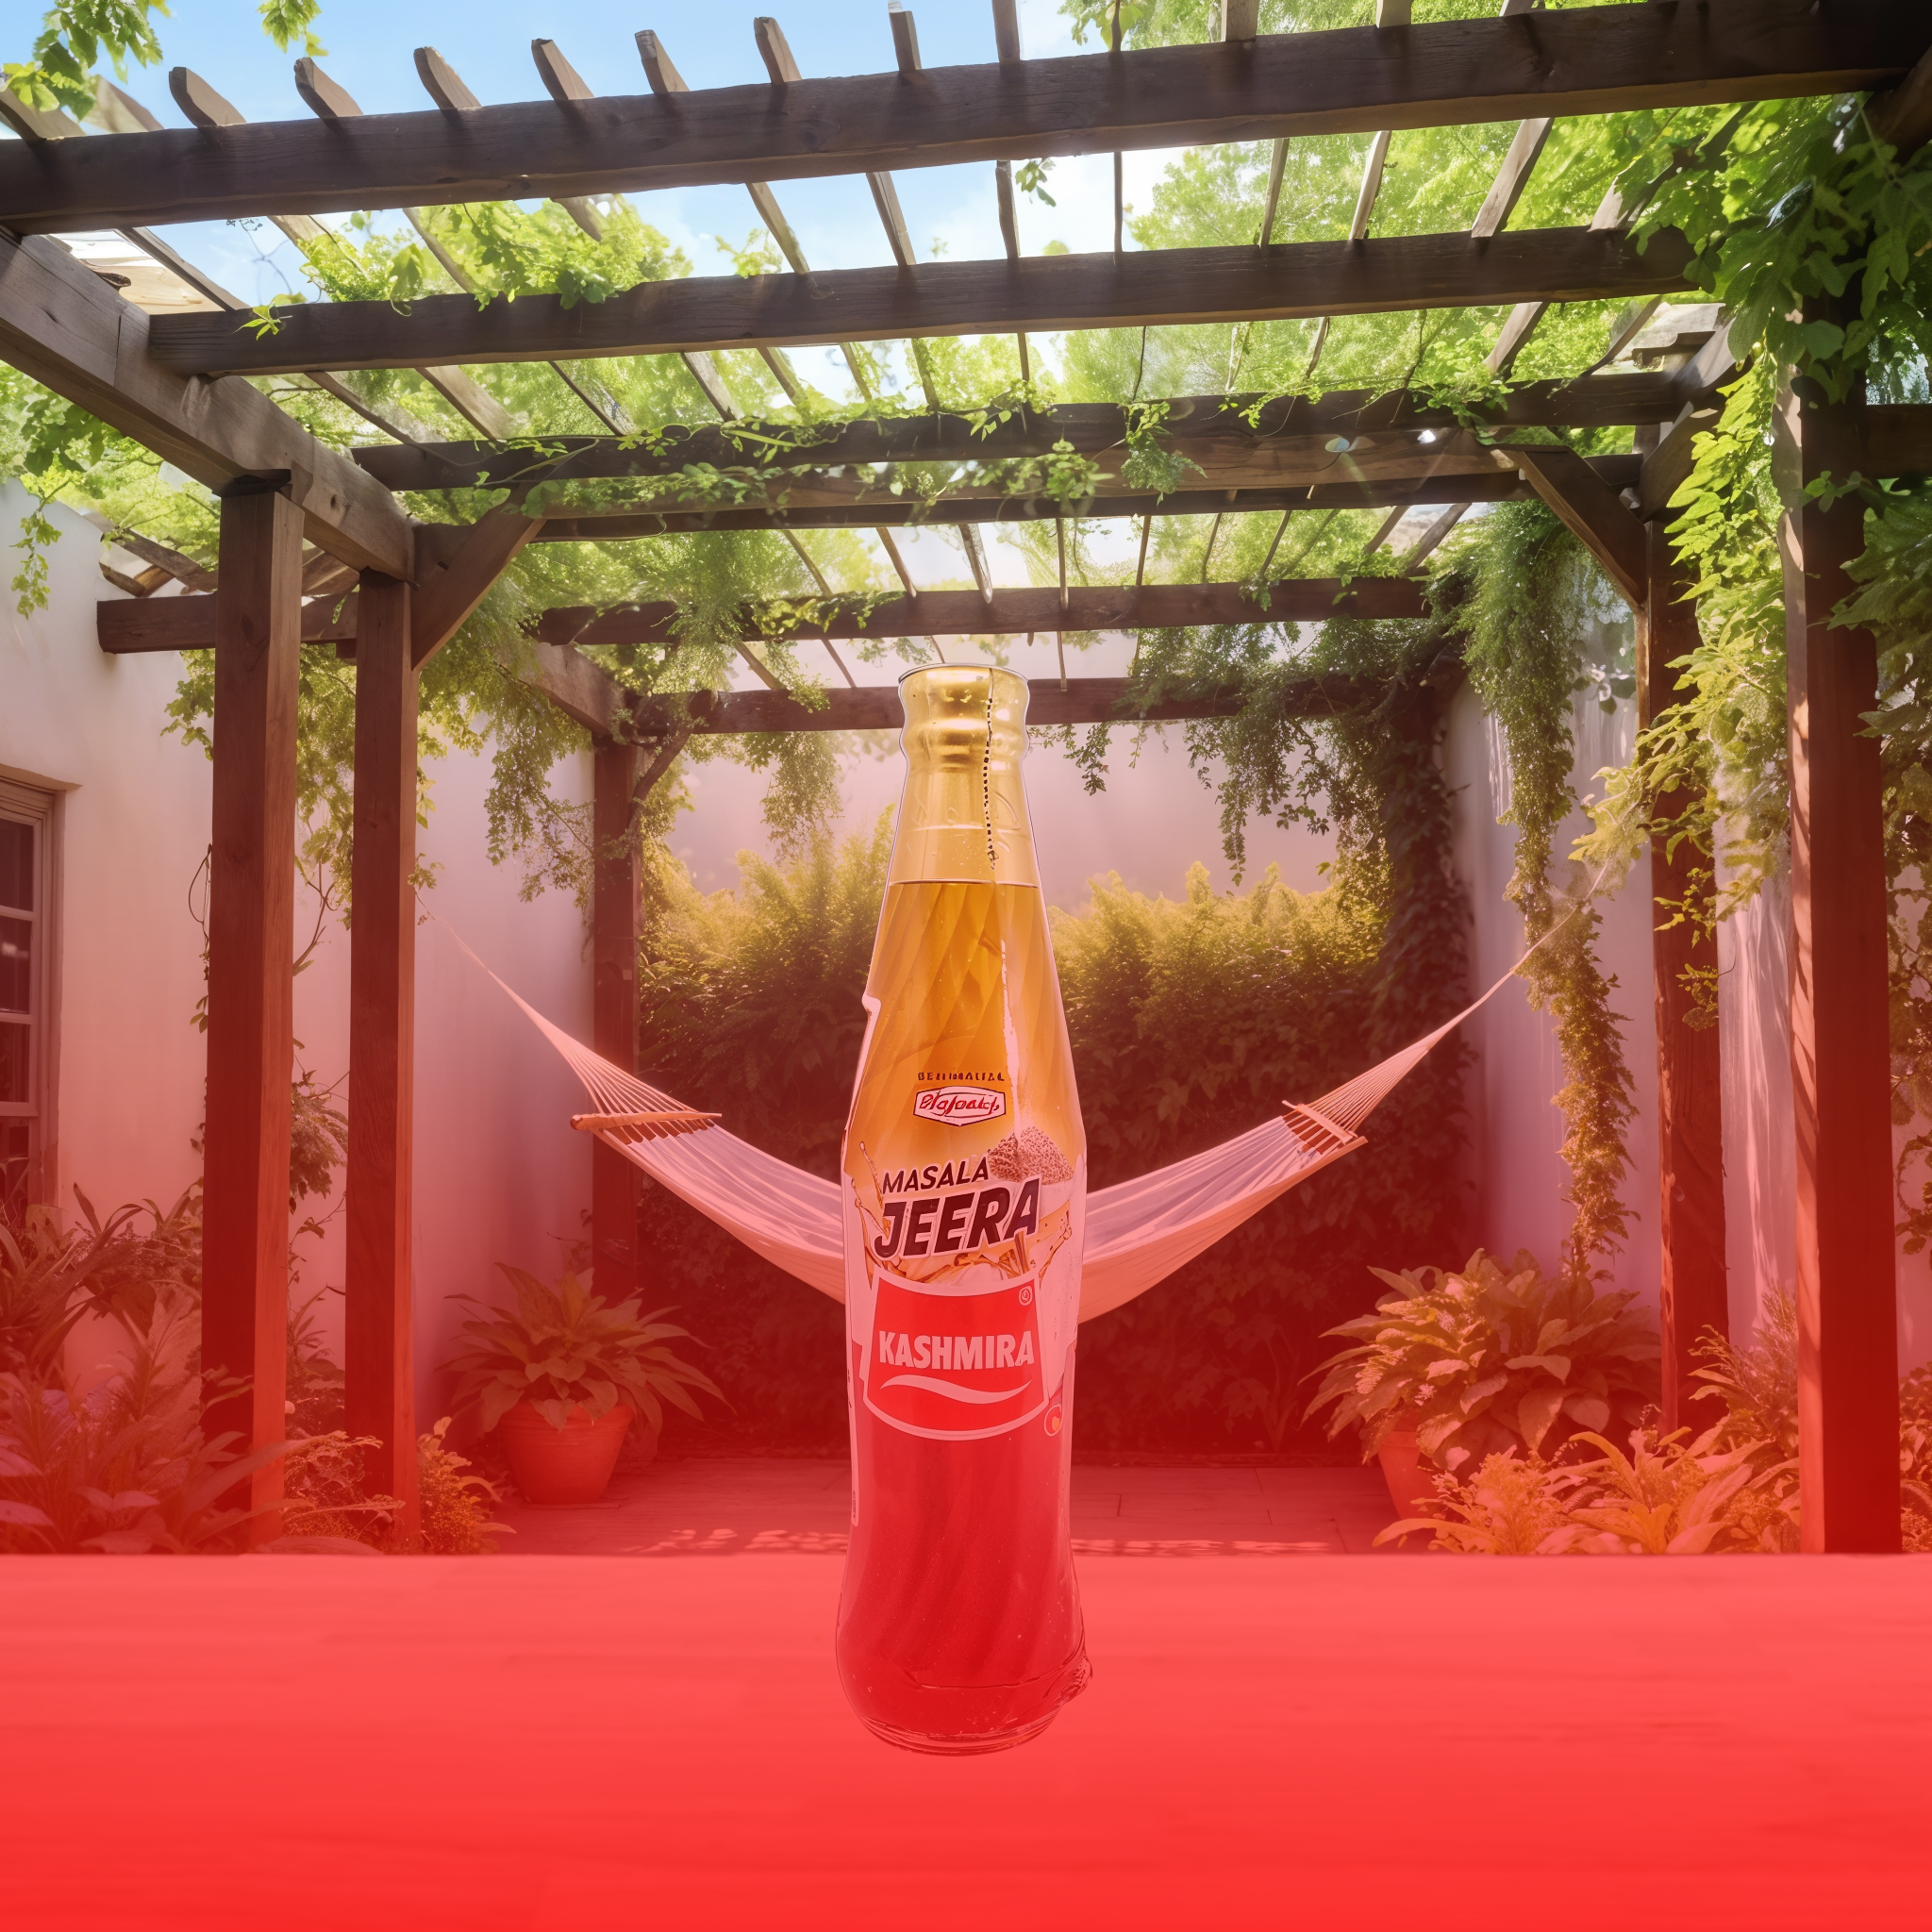

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

def add_bottom_gradient_overlay(image_path, primary_color):
    # Open and convert image to RGBA
    try:
      img = Image.open(image_path).convert('RGBA')
    except:
      img = image_path.convert('RGBA')
    width, height = img.size

    # Create a transparent overlay
    overlay = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Convert primary color to RGB tuple
    color_map = {
        'red': (255, 0, 0),
        'blue': (0, 0, 255),
        'green': (0, 255, 0)
    }

    if isinstance(primary_color, str):
        color = color_map.get(primary_color.lower(), (255, 0, 0))
    else:
        color = primary_color

    # Calculate gradient parameters
    gradient_height = int(height * 0.75)  # 75% of image height
    start_y = height - gradient_height

    # Create gradient overlay
    for y in range(start_y, height):
        # Calculate opacity (alpha) based on position
        progress = (y - start_y) / (height - start_y)
        alpha = int(204 * progress)  # 204 is 80% of 255

        # Draw line with calculated opacity
        draw.line([(0, y), (width, y)], fill=color + (alpha,))

    # Composite original image with overlay
    result = Image.alpha_composite(img, overlay)

    return result

#  Example usage:
image = add_bottom_gradient_overlay(im, 'red')
image

In [ ]:
def add_bottom_text(
    image_path: str,
    text: str,
    font_ratio: float = 0.1,
    font_path: Optional[str] = None,
    text_color: Tuple[int, int, int] = (0, 0, 0),
    gradient_end_color: Optional[Tuple[int, int, int]] = None,
    alignment: Literal['left', 'center', 'right'] = 'center',
    position_ratio: Tuple[float, float] = (0.5, 0.8),
    primary_color: Tuple[int, int, int] = (255, 255, 255)
) -> Image.Image:
    """
    Add text with a gradient overlay at the bottom of an image.

    This function combines a gradient overlay and text at the bottom of an image.

    Args:
        image_path: Path to the input image or a PIL.Image object.
        text: Text to add at the bottom of the image.
        font_ratio: Font size as a ratio of the image height.
        font_path: Path to the font file (.ttf). If None, the default font is used.
        text_color: RGB tuple for the text color.
        position_ratio: Tuple (x_ratio, y_ratio) for text position as a fraction of image width and height.
        primary_color: RGB tuple or color name for the gradient overlay. Supports 'red', 'blue', or 'green' as color names.
        gradient_end_color: Optional end color for the gradient effect.
        alignment: Text alignment ('left', 'center', 'right')

    Returns:
        PIL.Image: Image with a gradient overlay and bottom text.
    """
    # Add the gradient overlay
    gradient_image = add_bottom_gradient_overlay(image_path, primary_color)

    # Add text over the gradient
    result_image = add_text(
        gradient_image,
        text,
        font_ratio=font_ratio,
        font_path=font_path,
        color=text_color,
        gradient_end_color = gradient_end_color,
        position_ratio=position_ratio,
        alignment = alignment
    )

    return result_image



In [ ]:
def add_top_text(
    image_path: str,
    text: str,
    font_ratio: float = 0.1,
    font_path: Optional[str] = None,
    text_color: Tuple[int, int, int] = (0, 0, 0),
    gradient_end_color: Optional[Tuple[int, int, int]] = None,
    alignment: Literal['left', 'center', 'right'] = 'center',
    position_ratio: Tuple[float, float] = (0.5, 0.2),
    primary_color: Tuple[int, int, int] = (255, 255, 255)
) -> Image.Image:
    """
    Add text with a gradient overlay at the bottom of an image.

    This function combines a gradient overlay and text at the bottom of an image.

    Args:
        image_path: Path to the input image or a PIL.Image object.
        text: Text to add at the bottom of the image.
        font_ratio: Font size as a ratio of the image height.
        font_path: Path to the font file (.ttf). If None, the default font is used.
        text_color: RGB tuple for the text color.
        position_ratio: Tuple (x_ratio, y_ratio) for text position as a fraction of image width and height.
        primary_color: RGB tuple or color name for the gradient overlay. Supports 'red', 'blue', or 'green' as color names.
        gradient_end_color: Optional end color for the gradient effect.
        alignment: Text alignment ('left', 'center', 'right')

    Returns:
        PIL.Image: Image with a gradient overlay and bottom text.
    """
    # Add the gradient overlay
    gradient_image = add_top_gradient_overlay(image_path, primary_color)

    # Add text over the gradient
    result_image = add_text(
        gradient_image,
        text,
        font_ratio=font_ratio,
        font_path=font_path,
        color=text_color,
        gradient_end_color = gradient_end_color,
        position_ratio=position_ratio,
        alignment = alignment
    )

    return result_image



In [ ]:
i =add_bottom_text(im,  "Drink to boost you",font_path = 'models\models_assets\Fonts\Jersey15-Regular.ttf', text_color=(20, 47, 94), gradient_end_color = (0,0,0))

In [ ]:
import base64
from io import BytesIO

def llm(image, prompt):

    try:
        # Convert the PIL image to a base64 string
        buffered = BytesIO()
        image.save(buffered, format="PNG")  # Save the image to the buffer in PNG format
        image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

        client = Groq(api_key="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")
        completion = client.chat.completions.create(
            model="llama-3.2-11b-vision-preview",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        },
                        {
                          "type": "image_url",
                          "image_url": {
                              "url": f"data:image/jpeg;base64,{image_base64}",
                          },
                        }
                    ]
                }
            ],
            temperature=1,
            max_tokens=1024,
            top_p=1,
            stream=False,
            stop=None,
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Error during image to text conversion: {e}")
        return None


In [ ]:
# prompt: convert a to Tuple[int, int, int]

from typing import Tuple

def convert_to_tuple(input_value) -> Tuple[int, int, int]:
  """Converts the input to a Tuple[int, int, int].

  Args:
    input_value: The value to convert.

  Returns:
    A tuple of three integers, or None if the conversion fails.
  """
  try:
    if isinstance(input_value, tuple) and len(input_value) == 3:
      return tuple(int(x) for x in input_value)
    elif isinstance(input_value, str):
      # Attempt to parse string as a tuple
      parts = input_value.strip('()').split(',')
      if len(parts) == 3:
        return tuple(int(x.strip()) for x in parts)
    elif isinstance(input_value, list) and len(input_value) == 3:
        return tuple(int(x) for x in input_value)
  except ValueError:
    pass  # Handle cases where elements can't be converted to int

  return None  # Return None if the input cannot be converted



In [519]:
import random


def get_font_location(font_name=None):
    """
    Returns the font file location. If font_name is provided, returns that specific font's path.
    If no font_name is provided, returns a random font path.

    Args:
        font_name (str, optional): Name of the font to find

    Returns:
        str: Path to the font file or error message if font not found
    """
    font_files = [
        "Roboto-ExtraBold.ttf",
        "Roboto-Bold.ttf",
        "Roboto-Regular.ttf",
        "RockSalt-Regular.ttf",
        "AutourOne-Regular.ttf",
        "Gabriela-Regular.ttf",
        "Jersey15-Regular.ttf",
    ]

    if font_name:
        for font in font_files:
            if font_name.lower() in font.lower():  # Case-insensitive search
                return '\models_assets\Fonts' + font
        return f"Font '{font_name}' not found."
    else:
        return '\models_assets\Fonts' + random.choice(font_files)


def get_nepali_font_path():
    fonts = [
        "Kalam-Bold.ttf",
        "Kalam-Light.ttf",
        "Kalam-Regular.ttf",
        "NotoSansDevanagari-Bold.ttf",
        "NotoSansDevanagari-Light.ttf",
        "NotoSansDevanagari-Regular.ttf",
        "NotoSansDevanagari-ExtraBold.ttf"
    ]

    # Select a random font
    random_font = random.choice(fonts)

    # Return the full path
    return os.path.abspath('\models_assets\Fonts'+random_font)



In [520]:
get_font_location()

'/content/fonts/AutourOne-Regular.ttf'

In [521]:
from typing import Optional, Tuple, Literal
from PIL import Image

def add_smart_text(
    image_path: str,
    text: str = None,
    font_ratio: float = 0.1,
    font: Optional[str] = None,
    text_color: Tuple[int, int, int] = (0, 0, 0),
    gradient_end_color: Optional[Tuple[int, int, int]] = None,
    alignment: Literal['left', 'center', 'right'] = 'center',
    primary_color: Tuple[int, int, int] = None,
    placement: str = None,
) -> Image.Image:
    """
    Intelligently add text to either the top or bottom of an image based on image content analysis.
    If no text is provided, analyzes the image to generate a catchy advertising tagline.

    Uses an LLM to analyze the image and determine the optimal text placement to avoid
    covering important visual elements or maintain visual balance.

    Args:
        image_path: Path to the input image or a PIL.Image object.
        text: Text to add to the image. If None, generates text based on image analysis.
        font_ratio: Font size as a ratio of the image height.
        font: Name to the font file (.ttf). If None, the default font is used.
        text_color: RGB tuple for the text color.
        gradient_end_color: Optional end color for the gradient effect.
        alignment: Text alignment ('left', 'center', 'right')
        primary_color: RGB tuple for the gradient overlay.
        placement: 'Top' or 'Bottom'. Decides where to put overlay.

    Returns:
        PIL.Image: Image with text and gradient overlay added at the optimal position.
    """
    if font == 'nepali':
      font_path = get_nepali_font_path()
    else:
      font_path = get_font_location(font)

    if text is None:
      text_generation_prompt = """
      Analyze this product image and generate a short, catchy advertising tagline.
      Consider:
      1. Key product features and benefits
      2. Target audience appeal
      3. Emotional resonance
      4. Brand voice (if apparent)

      Respond with only the tagline.
      Do not include any symbols, formatting, or extra text.
      Keep it under 4 words for optimal impact.
      Make it memorable and action-oriented.
      return only tagline
      """
      while True:
        text = llm(im, text_generation_prompt).strip()
        if ('*' in text) or ('\"' in text) or ('\'' in text):
          continue
        if len(text.split()) <= 4:
          break

    if (placement == None):
      # Prompt for the LLM to analyze image content for placement
      analysis_prompt = """
      Analyze this image and determine whether text should be added to the top or bottom.
      Consider factors like:
      1. Important visual elements and their location
      2. Areas with less visual complexity
      3. Natural reading flow and visual hierarchy
      4. Contrast and readability

      Respond with either 'top' or 'bottom'.
      """

      # Get LLM's recommendation
      placement = llm(image_path, analysis_prompt).lower().strip()

    if primary_color is None or text_color is None:
      color_generation_prompt = f"""
      Analyze the provided image and return a JSON dictionary.
        Include the following fields with one word values:
        1. "overlay_color": give the rgb color only (e.g., (0,0,0), (20,22,78), (155,200,39)).
        2. "text_color": give the rgb color only (e.g., (0,0,0), (20,22,78), (155,200,39)).

        Do not include any information about the actual product, its brand, or its function. Respond strictly with the JSON dictionary and no additional text.

      """

      while True:
        a = llm(im,color_generation_prompt)
        print('color deciding', a)
        try:
            # Attempt to load as JSON
            a = json.loads(a)
        except json.JSONDecodeError:
            # If it fails, try to extract the JSON part (assuming it's within curly braces)
            import re
            match = re.search(r'\{(.*?)\}', a, re.DOTALL)
            if match:
                try:
                    a = json.loads(match.group(0))
                except json.JSONDecodeError:
                    print(f"Error: Could not parse JSON from LLM response: {a}")
                    continue  # Continue to the next iteration of the loop
            else:
                print(f"Error: Could not find JSON within LLM response: {a}")
                continue  # Continue to the next iteration of the loop

        # If JSON loading is successful, proceed
        if primary_color == None:
          primary_color = convert_to_tuple(a['overlay_color'])
        if text_color == None:
          text_color = convert_to_tuple(a['text_color'])
        if (text_color) != None and (primary_color) != None:
          break





    # Set position ratio based on placement
    if placement.lower() == 'top':
        position_ratio = (0.5, 0.2)
        return add_top_text(
            image_path=image_path,
            text=text,
            font_ratio=font_ratio,
            font_path=font_path,
            text_color=text_color,
            gradient_end_color=gradient_end_color,
            alignment=alignment,
            position_ratio=position_ratio,
            primary_color=primary_color
        )
    else:  # Default to bottom if LLM response is unclear
        position_ratio = (0.5, 0.8)
        return add_bottom_text(
            image_path=image_path,
            text=text,
            font_ratio=font_ratio,
            font_path=font_path,
            text_color=text_color,
            gradient_end_color=gradient_end_color,
            alignment=alignment,
            position_ratio=position_ratio,
            primary_color=primary_color
        )

In [532]:
i = add_smart_text(im,"Drink",gradient_end_color=(0,0,255),primary_color = (127,139,152), text_color= (0,0,0))

#product dict Function
(run only when product is added on all the product images)

In [ ]:
import json

def convert_text_to_dict(text_description):
    try:
        # Attempt to parse the text as a JSON object
        data = json.loads(text_description)
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        # Handle the error gracefully (e.g., return an empty dictionary or None)
        return None


def product_dict(image):
  product_analysis_prompt = """
  Analyze the provided image and return a JSON dictionary describing only the visual attributes of the main object in the image.
  Include the following fields with detailed descriptions:
  1. "orientation": Describe the position or alignment of the object, including its angle (e.g., upright, tilted, flat), the direction it is facing (e.g., front-facing, side-facing), and any notable details about its positioning (e.g., if it is open, closed, folded, etc.).
  2. "lighting": Describe the type, intensity, and source of lighting on the object (e.g., bright natural light from the left, dim artificial light from above, shadowed on the right side).
  3. "color": Describe the dominant or noticeable colors of the object and any patterns or gradients observed (e.g., solid matte black, metallic silver with blue accents).
  4. "visual_texture": Describe the surface appearance of the object, including specific details about its texture (e.g., smooth and glossy, rough and uneven, polished with visible grains).

  Do not include any information about the actual product, its brand, or its function. Respond strictly with the JSON dictionary and no additional text.
  """
  try:
    imggg = Image.open(image)
  except:
    imggg = image

  text_description = llm(imggg, product_analysis_prompt)
  product_dict = convert_text_to_dict(text_description)

  if product_dict:
    return product_dict
  else:
    return None


In [ ]:
product_dict('/content/file.png')

{'orientation': 'upright, front-facing',
 'color': 'silver and black dominant colors, blue accents on neck and cap',
 'visual_texture': 'Smooth to the touch, shiny glass body, no visible grain or texture on body, smooth slightly lighter and glossy reflective surface on neck and cap',
 'lighting': 'bright soft white lighting from the left side, no harsh shadows on bottle body, darker and subtle gradation of light reflecting on the body'}

In [ ]:
placement = 'top'
color_generation_prompt = f"""
 Analyze the provided image and return a JSON dictionary.
  Include the following fields with one word values:
  1. "overlay_color": give the rgb color only (e.g., (0,0,0), (20,22,78), (155,200,39))
  2. "font_color": give the rgb color only (e.g., (0,0,0), (20,22,78), (155,200,39))

  Do not include any information about the actual product, its brand, or its function. Respond strictly with the JSON dictionary and no additional text.

"""



a =llm(im,color_generation_prompt)

In [ ]:
a

'{"overlay_color": (160,176,58), "font_color": (0,0,0)}'

(0, 0, 255)